In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import SGD, Adam 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import sys, os
import cv2
from gapcv.vision import Images
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
print(tf.__version__)

2.3.1


# Note you will need to download the H5 file to use the next line of code. You can file the file here. You can use:

https://drive.google.com/file/d/1WLyKrWk8sjrRvpghmbgU5ZisdChTSa0J/view?usp=sharing

In [1]:
# You can use zipfile to unpack the h5 file, this is just an example below
import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

# The Code continues here:

In [ ]:
# Load data augment=['flip=both', 'edge', 'zoom=0.3', 'denoise']
# this will stream the data from the `my_new_file.h5` file so you don't overload your memory
images = Images('dress_images',config=['flatten']) # augment if it's needed if not use just Images(config=['stream']), norm 1.0/255.0 by default.
images.load('dress_images')
images.split = 0.2, 42
CVX_train, CVX_test, CVY_train, CVY_test = images.split

#Metadata

print('images train')
print('Time to load data set:', images.elapsed)
print('Number of images in data set:', images.count)
#print('classes:', images.classes)

images train
Time to load data set: 02:53:34
Number of images in data set: 8792


In [ ]:
CVX_train.shape

(8702, 128, 128, 3)

In [ ]:
def plot_sample(imgs_set, labels_set, img_size=(12,12), columns=4, rows=4, random=False):
    """
    Plot a sample of images
    """
    
    fig=plt.figure(figsize=img_size)
    
    for i in range(1, columns*rows + 1):
        if random:
            img_x = np.random.randint(0, len(imgs_set))
        else:
            img_x = i-1
        img = imgs_set[img_x]
        ax = fig.add_subplot(rows, columns, i)
        ax.set_title(str(labels_set[img_x]))
        plt.axis('off')
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

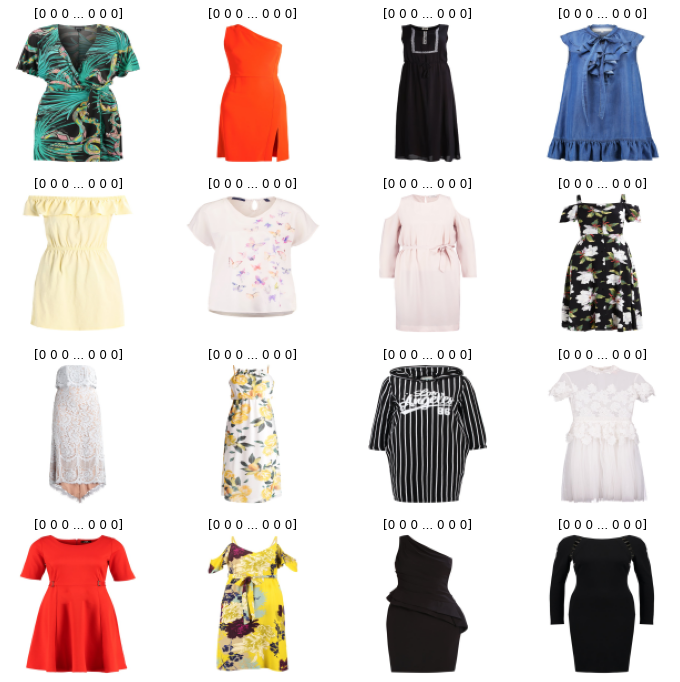

In [ ]:
plot_sample(CVX_train, CVY_train, random=True)

In [ ]:
# GAPCV
trial = CVX_train
N, H, W, RGB = trial.shape
D = H * W * RGB
trial = trial.reshape((N, -1))
trial.shape

(8702, 49152)

In [ ]:
latent_dim = 100

In [ ]:
#build the generator 
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(D, activation="tanh")(x)

  model = Model(i,x)
  return model


In [ ]:
# build the discriminator
def build_discriminator(img_size):
  i = Input(shape=img_size,)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation="sigmoid")(x)
  model = Model(i,x)
  return model

In [ ]:
# Build and compile discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss="binary_crossentropy",
    optimizer=Adam(0.0002, 0.5),
    metrics=["accuracy"]
)

# This doesn't make sense
generator = build_generator(latent_dim)
z = Input(shape=(latent_dim,))
img = generator(z)

# freeze the layers of the discriminator, and feed the generator model in with parameter of latent_space
discriminator.trainable = False
fake_pred = discriminator(img)

# Create combined model 
combined_model = Model(z, fake_pred)
combined_model.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5))

In [ ]:
# /////// Train the GAN /////////

# Config 
batch_size = 32
epochs = 30000
sample_period = 200

# Create batch labels to use when calling train_on_batch 
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images 
if not os.path.exists("gan_images"):
  os.makedirs("gan_images")

In [ ]:
ones.shape

(32,)

In [ ]:
# Function to create a grid of random samples from the generator 
# and save them to a file 

def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H,W,-1))
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [ ]:
# main training loop 

for epoch in range(epochs):

  #### Train discriminator ####

#   # Select a random batch of images
  idx = np.random.randint(0, trial.shape[0], batch_size)
  real_imgs = trial[idx]

  # Generate fake images 
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)

  # Train the discriminator, both loss and accuracy are returned 
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc = 0.5 * (d_acc_real + d_acc_fake)

  #### Train the generator ####
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)

  # Save the losses 
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
    
  if epoch % sample_period == 0:
    sample_images(epoch)

epoch: 1/30000, d_loss: 0.68,       d_acc: 0.34, g_loss: 0.64
epoch: 101/30000, d_loss: 1.02,       d_acc: 0.78, g_loss: 3.97
epoch: 201/30000, d_loss: 0.21,       d_acc: 0.91, g_loss: 1.77
epoch: 301/30000, d_loss: 1.23,       d_acc: 0.55, g_loss: 0.27
epoch: 401/30000, d_loss: 0.26,       d_acc: 0.92, g_loss: 1.16
epoch: 501/30000, d_loss: 0.15,       d_acc: 1.00, g_loss: 1.49
epoch: 601/30000, d_loss: 0.46,       d_acc: 0.69, g_loss: 2.30
epoch: 701/30000, d_loss: 0.23,       d_acc: 0.94, g_loss: 2.29
epoch: 801/30000, d_loss: 0.25,       d_acc: 0.94, g_loss: 1.33
epoch: 901/30000, d_loss: 0.27,       d_acc: 0.98, g_loss: 1.18
epoch: 1001/30000, d_loss: 0.27,       d_acc: 0.95, g_loss: 1.23
epoch: 1101/30000, d_loss: 0.27,       d_acc: 0.95, g_loss: 1.32
epoch: 1201/30000, d_loss: 0.31,       d_acc: 0.94, g_loss: 1.28
epoch: 1301/30000, d_loss: 0.26,       d_acc: 1.00, g_loss: 1.30
epoch: 1401/30000, d_loss: 0.32,       d_acc: 0.98, g_loss: 1.20
epoch: 1501/30000, d_loss: 0.32,     

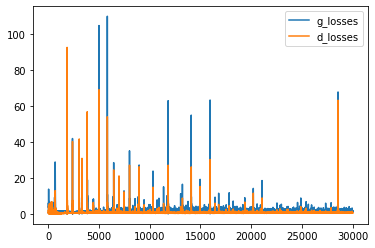

In [ ]:
plt.plot(g_losses, label="g_losses")
plt.plot(d_losses, label="d_losses")
plt.legend()

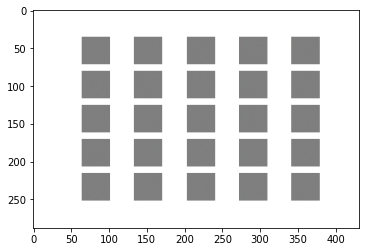

In [ ]:
from skimage.io import imread 
a = imread('gan_images/0.png')
plt.imshow(a)

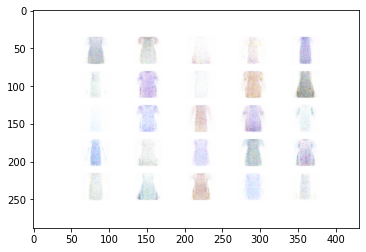

In [ ]:
from skimage.io import imread 
a = imread('gan_images/10000.png')
plt.imshow(a)

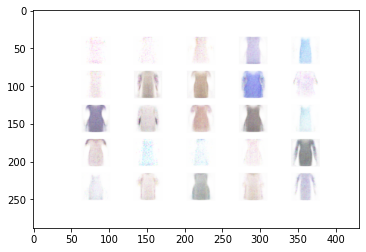

In [ ]:
from skimage.io import imread 
a = imread('gan_images/20000.png')
plt.imshow(a)

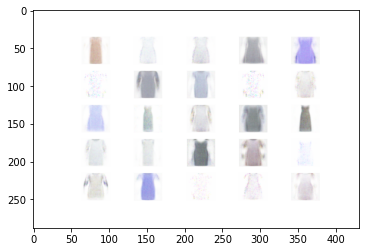

In [ ]:
from skimage.io import imread 
a = imread('gan_images/29800.png')
plt.imshow(a)